In [25]:
from pydub import AudioSegment
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import operator
import numpy as np
import IPython

In [2]:
# predtimesteps is dictated by model
predtimesteps = 847
cliplen = 10000
lag = 0 # this will dictate overlap necessary
overlap = 0 # old formula = round(((cliplen / predtimesteps) * lag) + 1) # rounding up to nearest ms here
timesteplen = cliplen / predtimesteps
print("overlap in ms is " + str(overlap))
print("length of each timestep in ms is " + str(timesteplen))

overlap in ms is 0
length of each timestep in ms is 11.806375442739078


In [3]:
# Creating 10-sec wav clips out of episodes
audiofolder = '/Users/Jack/Developer/friends/allaudio/'
seasonfilter = 5

for filename in os.listdir(audiofolder):
    if not filename.startswith('.'):
        season = filename[9:11]
        if int(season) == seasonfilter:
            episode = filename[12:14]
            filepath = audiofolder + filename
            file = AudioSegment.from_file(filepath)
    #         print("Length of file is " + str(len(file)))

            startcut = 0
            endcut = startcut + cliplen
            count = 1

            while startcut < len(file):
                #create clip here
                clip = file[startcut:endcut]
                if len(clip) < cliplen:
                    break
                else:
                    clip.export("/Users/Jack/Developer/friends/clips/s" + str(season) + "e" + str(episode) + "n" + str(count) + "beg" + str(startcut) + "end" + str(endcut) + ".wav", format="wav")



    #             print("clip num is " + str(count))
    #             print("clip start is " + str(startcut))
    #             print("clip end is " + str(endcut))
    #             print("clip len is " + str(len(clip)))
                #increment values for next clip
                startcut += (cliplen - overlap)
                endcut = min(startcut + cliplen, len(file))
                count += 1


In [4]:
# master sort

listtosort = []
clipsfolder = '/Users/Jack/Developer/friends/clips/'

for filename in os.listdir(clipsfolder):
    if not filename.startswith('.'):
        season = int(filename[1:3])
        if season == seasonfilter:
            episode = int(filename[4:6])
            findbegstart = filename.find("beg")
            findendstart = filename.find("end")
            findendend = filename.find(".")
            begtimestart = findbegstart + 3
            endtimestart = findendstart + 3
            begtime = int(filename[begtimestart:findendstart])
            endtime = int(filename[endtimestart:findendend])
            listtosort.append([season, episode, begtime, endtime, filename])


sortedclips = sorted(listtosort, key = operator.itemgetter(0, 1, 2))
# print(sortedclips)


file duration is 10.0
filename is s05e01n40beg390000end400000.wav
number of channels is 1
num of time steps in spectrogram is 861
num of frequencies in spectrogram is 257


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


shape of preX is (3190, 861, 257)


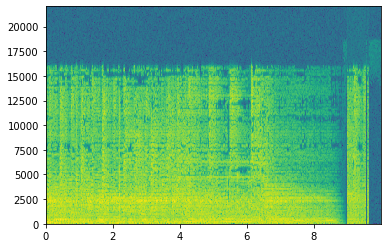

In [5]:
# Creating X numpy array of shape (number of clips, number of frequencies, number of spectrogram timesteps)

count = 1
clipsfolder = '/Users/Jack/Developer/friends/clips/'
# totalclips = len(sortedclips)
# print(totalclips)
spectdata = []

for info in sortedclips:
    filename = info[4]
    filepath = clipsfolder + filename
    FS, data = wavfile.read(filepath) # read wav file
#     print("Number of channels is " + str(data.ndim))
    pxx, freqs, bins, im = plt.specgram(data, Fs=FS, NFFT=512, noverlap=0)  # building plot and spectrogram
    Tx = pxx.shape[1] # represents number of time steps in spectrogram
    n_freq = pxx.shape[0] # represents number of frequencies in spectrogram
    pxxtransposed = pxx.T
#     print("filename is " + str(filename))
#     print("Shape of pxxtransposed is " + str(pxxtransposed.shape))
    spectdata.append(pxxtransposed)
    if count == 40:
        print("file duration is " + str(len(data) / float(FS)))
        print("filename is " + str(filename))
        print("number of channels is " + str(data.ndim)) # 1 channel now because we are merging in stereo
        print("num of time steps in spectrogram is " + str(Tx))
        print("num of frequencies in spectrogram is " + str(n_freq))
#         plt.show() # plot the spectrogram
    count += 1
preX = np.stack(spectdata, axis=0)
print("shape of preX is " + str(preX.shape))


In [6]:
# Save preX
modeldatafolder = '/Users/Jack/Developer/friends/modeldata/'

np.save(modeldatafolder + 'preX' + str(seasonfilter) + '.txt', preX)

In [7]:
# # Preprocessing Y-labels
# # Creating dict of laugh labels for hand-labeled episodes

# labeldict = {}
# laughlabelsfolder = '/Users/Jack/Developer/friends/laughlabels/'

# for filename in os.listdir(laughlabelsfolder):
#     if not filename.startswith('.'):
#         season = filename[0:2]
#         episode = filename[2:4]
#         labeldict[season + episode] = []
#         htmlpath = laughlabelsfolder + filename
#         with open(htmlpath) as f:
#             for line in f:
#                 if '\\' not in line:
#                     # converting to ms
# #                     print(season, episode)
# #                     print(line)
#                     pair = [float(i) * 1000 for i in line.split()]
#                     labeldict[season + episode].append(pair)
#                 else:
#                     continue
# print(labeldict)


In [8]:
# # Creating Y numpy array of shape (number of clips, number of predicted timesteps, 1)

# for i, info in enumerate(sortedclips):
#     season = info[0]
#     dictseason = str(season).zfill(2)
#     episode = info[1]
#     dictepisode = str(episode).zfill(2)
#     begtime = info[2]
#     endtime = info[3]
#     workinglabels = labeldict[dictseason + dictepisode]
#     cliplabels = []
#     increment = (endtime - begtime) / predtimesteps
#     for count in range(predtimesteps): # range is from 0 to end - 1 for example
#         # this skips t-0 as a timestep but includes last possible timestep (t-1000 if there are 1000 timesteps)
#         timestep = begtime + increment + (count * increment)
#         timesteplabel = 0
#         for pair in workinglabels:
#             if pair[0] <= timestep <= pair[1]:
#                 timesteplabel = 1
#         cliplabels.append(timesteplabel)
# #     print("Length of cliplabels is " + str(len(cliplabels)))
#     sortedclips[i].append(cliplabels)
# print(sortedclips)
    

In [9]:
# # Add lag to y-values
# sortedlagclips = []

# for info in sortedclips:
#     beforelag = info[5]
#     afterlag = beforelag[:-lag or None]
#     pos = 0
#     value = 0
#     for i in range(lag):
#         afterlag.insert(pos, value)
#     sortedlagclips.append([info[0], info[1], info[2], info[3], info[4], afterlag])
# print(sortedlagclips)


In [10]:
# # Create preY
# preYlist = []

# for info in sortedlagclips:
#     labels = info[5]
#     preYlist.append(labels)
# preY = np.stack(preYlist, axis=0)
# preY = np.expand_dims(preY, axis=2)
# print(preY.shape)

In [11]:
# # Save preY
# modeldatafolder = '/Users/Jack/Developer/friends/modeldata/'

# np.save(modeldatafolder + 'preY.txt', preY)

In [12]:
# from sklearn.model_selection import train_test_split

X = preX
# y = preY

# # splitting train (80%) and test (20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Taking train (80%) and removing 25% to create val (20% overall) and leaves train at 60% overall
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# print("Shape of X_train and y_train are " + str(X_train.shape) + ", " +  str(y_train.shape))
# print("Shape of X_dev and y_dev are " + str(X_dev.shape) + ", " +  str(y_dev.shape))
# print("Shape of X_test and y_test are " + str(X_test.shape) + ", " +  str(y_test.shape))

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.metrics import Precision, Recall

Using TensorFlow backend.


In [14]:
def model(input_shape):
    
    X_input = Input(shape = input_shape)
    
    # Convolution layer
    X = Conv1D(filters=256,kernel_size=15,strides=1)(X_input)
    X = BatchNormalization()(X)
    X = output_x = Activation("relu")(X)
    X = Dropout(rate=0.8)(X)
    
    # GRU Layer 1
    X = GRU(units=256, return_sequences = True)(X)
    X = Dropout(rate=0.8)(X)
    X = BatchNormalization()(X)
    
    # GRU Layer 2
    X = GRU(units=256, return_sequences = True)(X)
    X = Dropout(rate=0.8)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.8)(X)
    
    # Time-Distributed Dense Layer with Sigmoid
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model
    

In [15]:
model = model(input_shape = (X.shape[1], X.shape[2]))

In [16]:
modelfolder = '/Users/Jack/Developer/friends/modelweights/'

model.load_weights(modelfolder + 'modelweights.h5')

In [17]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", Precision(), Recall()])

In [18]:
# loss, acc, prec, recall = model.evaluate(X_dev, y_dev)
# F1 = 2 * ((prec * recall) / (prec + recall))
# print("Dev set accuracy = ", acc)
# print("Dev set precision = ", prec)
# print("Dev set recall = ", recall)
# print("Dev set F1 = ", F1)


In [19]:
# then predict for all clips
rawprobs = model.predict(X)

In [20]:
print(rawprobs.shape)

(3190, 847, 1)


In [21]:
# any probs above 80% are counted as laughter
probs = rawprobs[:, :, 0]
preds = np.where(probs > 0.8, 1, 0)
print(preds.shape)

(3190, 847)


s05e15n5beg40000end50000.wav


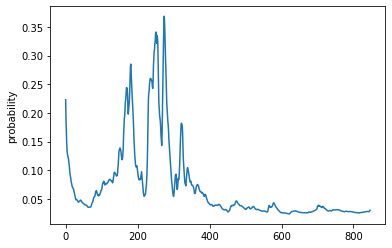

In [38]:
# Clip test
# S5E15 starts at clipnum 2100
clipnum = 1866
clipdata = X[clipnum]
clipdata = np.expand_dims(clipdata, axis=0)
preds = model.predict(clipdata)
probs = preds[0, :, 0]

# audio output
clipsfolder = '/Users/Jack/Developer/friends/clips/'
clipinfo = sortedclips[clipnum]
filename = clipinfo[4]
filepath = clipsfolder + filename
print(filename)
IPython.display.display(IPython.display.Audio(filepath))

# probabilities graph
plt.subplot(1, 1, 1)
plt.plot(probs)
plt.ylabel('probability')
plt.show()


In [208]:
epclipcounts = {}        

for i, info in enumerate(sortedclips):
    season = info[0]
    episode = info[1]
    begtime = info[2]
    endtime = info[3]
    filename = info[4]
    if season == seasonfilter:
        if episode not in epclipcounts:
            epclipcounts[episode] = 1
        else:
            epclipcounts[episode] += 1
print(epclipcounts)

{1: 175, 2: 143, 3: 145, 4: 137, 5: 169, 6: 146, 7: 139, 8: 138, 9: 149, 10: 137, 11: 165, 12: 177, 13: 141, 14: 139, 15: 139, 16: 136, 17: 285}


In [209]:
totalclips = 0
for ep, epcount in epclipcounts.items():
    totalclips += epcount
print("Total clips is " + str(totalclips) + " and should be equal to " + str(preds.shape[0]))
    

Total clips is 2660 and should be equal to 2660


In [210]:
startpos = 0
predsbyep = {}

for ep, epcount in epclipcounts.items():
    key = "s" + str(seasonfilter).zfill(2) + "e" + str(ep).zfill(2)
    endpos = startpos + epcount
    print(startpos, endpos)
    predsbyep[key] = preds[startpos:endpos]
    print(key, predsbyep[key].shape)
    startpos += epcount

0 175
s10e01 (175, 847)
175 318
s10e02 (143, 847)
318 463
s10e03 (145, 847)
463 600
s10e04 (137, 847)
600 769
s10e05 (169, 847)
769 915
s10e06 (146, 847)
915 1054
s10e07 (139, 847)
1054 1192
s10e08 (138, 847)
1192 1341
s10e09 (149, 847)
1341 1478
s10e10 (137, 847)
1478 1643
s10e11 (165, 847)
1643 1820
s10e12 (177, 847)
1820 1961
s10e13 (141, 847)
1961 2100
s10e14 (139, 847)
2100 2239
s10e15 (139, 847)
2239 2375
s10e16 (136, 847)
2375 2660
s10e17 (285, 847)


In [211]:
# Save to predsbyep folder
predsbyepfolder = '/Users/Jack/Developer/friends/predsbyep/'

for ep, array in predsbyep.items():
    np.save(predsbyepfolder + ep + ".txt", array)

In [213]:
# All seasons at once starting here
laughrangesdict = {}
minlaughlen = 400 # in ms - this decides the minimum length to be considered a laugh
concatlaugh = 100 # in ms - this decides the maximum length in between two laughs in order to join them together
consecsteps = int(minlaughlen / timesteplen) # min number of timesteps in a row to register as laugh
consecnolaugh = int(concatlaugh / timesteplen) # max number of no-laugh timesteps in a row to combine two laughs
print("min # of timesteps in a row to register a laugh is " + str(consecsteps))
print("max # of timesteps in a row to combine two laughs is " + str(consecnolaugh))

for filename in os.listdir(predsbyepfolder):
    if not filename.startswith('.'):
        season = filename[1:3]
        episode = filename[4:6]
#         if int(season) == seasonfilter:
        ep = np.load(predsbyepfolder + filename)
        flatep = ep.flatten()
        switchingindices = []
        # finding all indices where the value switches from the previous index (0 to 1 or 1 to 0)
        for i, step in enumerate(flatep):
            # starting first value at 0 no matter what
            if i == 0:
                flatep[i] = 0
            # putting last value as zero so we get even number of switches no matter what
            elif i == len(flatep) - 1:
                flatep[i] = 0
                # may need to switch on last value if value before was 1 (in order to keep switches even)
                if flatep[i - 1] == 1:
                    switchingindices.append(i)
            # checking to see if we should switch on any given value (except first or last value handled above)
            elif flatep[i] != flatep[i - 1]:
                switchingindices.append(i)
#             print(len(switchingindices))
#             print(switchingindices)
        # if value is within +- consecnolaugh steps from another value, we remove both values (separately) from list
        smoothindices = []
        for i, value in enumerate(switchingindices):
            # need to handle 0 and last index separately so i + 1 and i - 1 will always exist below
            if i == 0:
                smoothindices.append(value)
            # need to handle 0 and last index separately so i + 1 and i - 1 will always exist below
            elif i == len(switchingindices) - 1:
                smoothindices.append(value)
            # this means it represents beginning of laugh, so we check end of last laugh to see how far away that was
            elif i % 2 == 0:
                if value - switchingindices[i - 1] > consecnolaugh:
                    smoothindices.append(value)
            # this means it represents end of laugh, so we check beginning of next laugh to see how far apart that is
            elif i % 2 != 0:
                if abs(value - switchingindices[i + 1]) > consecnolaugh:
                    smoothindices.append(value)
        # We should have pairs at this point so number of indices shoud be even (thus divisible by 2 evenly)
        if len(smoothindices) % 2 != 0:
            print("WE HAVE AN ERROR")
            break
#             print(len(smoothindices))
#             print(smoothindices)
        # combining the pairs into their own sublists now
        coupledlist = []
        templist = []
        for i, timestep in enumerate(smoothindices):
            if i % 2 == 0:
                templist.append(timestep)
            if i % 2 != 0:
                templist.append(timestep)
                coupledlist.append(templist)
                templist = []
#             print(len(coupledlist))
#             print(coupledlist)
        # removing all laughter that is deemed too short in length
        minlaughlist = [pair for pair in coupledlist if pair[1] - pair[0] >= consecsteps]
#             print(len(minlaughlist))
#             print(minlaughlist)
        # translating from timesteps into ms
        laughranges = []
        for pair in minlaughlist:
            templist = [int(step * timesteplen) for step in pair]
            laughranges.append(templist)
#             print(len(laughranges))
#             print(laughranges)
        laughrangesdict[season + episode] = laughranges
print(len(laughrangesdict.keys()))
print(laughrangesdict)


min # of timesteps in a row to register a laugh is 33
max # of timesteps in a row to combine two laughs is 8
234
{'0220': [[4309, 4698], [12054, 13624], [24533, 26009], [37603, 39386], [43494, 44899], [59256, 60956], [65242, 65879], [70236, 71841], [72172, 72892], [76871, 78984], [136646, 137874], [141381, 144403], [149126, 150625], [154368, 156021], [164273, 165289], [173778, 174628], [177874, 179220], [181263, 182644], [190401, 192160], [198689, 199492], [210968, 212384], [221416, 222337], [229055, 229964], [236151, 236729], [239161, 240484], [243258, 245029], [262066, 263152], [271499, 273388], [276493, 278181], [284415, 285053], [302302, 303565], [312349, 313955], [325383, 326753], [332361, 334179], [342715, 344203], [363187, 365230], [378347, 379752], [391688, 393093], [401463, 403282], [414687, 415997], [432420, 433766], [435867, 437497], [446092, 448099], [449716, 451263], [468642, 469693], [483128, 484698], [485702, 488146], [491806, 493754], [499397, 500436], [508583, 509634],

In [216]:
import sqlite3

# Connecting to friendsdb SQLite database and creating laughs table
conn = sqlite3.connect('/Users/Jack/Developer/friends/friendsdb.sqlite')
cur = conn.cursor()

cur.executescript('''
CREATE TABLE IF NOT EXISTS laughs (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    season INTEGER,
    episode INTEGER,
    beg INTEGER,
    end TEXT,
    UNIQUE(season, episode, beg)
);
''')

In [217]:
for seasep, eplaughs in laughrangesdict.items():
    season = int(seasep[0:2])
    episode = int(seasep[2:4])
    for laugh in eplaughs:
        beg = laugh[0]
        end = laugh[1]
        cur.execute('''INSERT OR REPLACE INTO laughs (season, episode, beg, end)
            VALUES ( ?, ?, ?, ? )''', ( season, episode, beg, end ) )
        conn.commit()
    



In [218]:
# Adding column to laughs table in SQLite so we can attribute the laugh to a char
addColumn = "ALTER TABLE laughs ADD COLUMN char TEXT"

cur.execute(addColumn)